In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 28.8 MB/s 


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
!pip install kaggle --upgrade

In [ ]:
!pip install kaggle -q      # At first, I suspect the kaggle API lose effect so it doesn't have .kaggle folder. (not working)
!rm -rf /root/.kaggle.      # when I created the folder, it says the file or dir already exits
!mkdir /root/.kaggle        # successful
!mv kaggle.json /root/.kaggle/kaggle.json    # not sure if I have to use full destination path, I previously only used /root/.kaggle and it failed. Don't have time to validate this thought.
!ls /root/.kaggle/kaggle.json
# !mv /content/kaggle.json ~/.kaggle/kaggle.json

/root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d meetnagadia/kvasir-dataset

 99% 1.14G/1.15G [00:08<00:00, 149MB/s]
100% 1.15G/1.15G [00:08<00:00, 143MB/s]


In [ ]:
!mv '/content/kvasir-dataset.zip' '/content/drive/MyDrive/Gastrointestinal Cancer'

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Gastrointestinal Cancer/kvasir-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Gastrointestinal Cancer')

## Loading Data

In [ ]:
positional_emb = True
conv_layers = 4
projection_dim = 128
input_shape=(128,128,3)
num_classes=8
num_heads = 2
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 30
image_size = 128
from sklearn.utils import shuffle

In [ ]:
import os,cv2
DATA=[]
for i,folder in enumerate(os.listdir('/content/drive/MyDrive/Gastrointestinal Cancer/kvasir-dataset')):
  for imgs in os.listdir(f'/content/drive/MyDrive/Gastrointestinal Cancer/kvasir-dataset/{folder}'):
    image=cv2.imread(f'/content/drive/MyDrive/Gastrointestinal Cancer/kvasir-dataset/{folder}/{imgs}')
    image=cv2.resize(image,(128,128))/255.0
    DATA.append((image,i))
DATA=shuffle(np.array(DATA))
Images=Images=np.array([ i for i in DATA[:,0]]).reshape((4000,128,128,3))
Labels = keras.utils.to_categorical(DATA[:,1], num_classes)
Images.shape,Labels.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


((4000, 128, 128, 3), (4000, 8))

In [ ]:
x_train,x_test,y_train,y_test=Images[:3600],Images[3600:],Labels[:3600],Labels[3600:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3600, 128, 128, 3), (400, 128, 128, 3), (3600, 8), (400, 8))

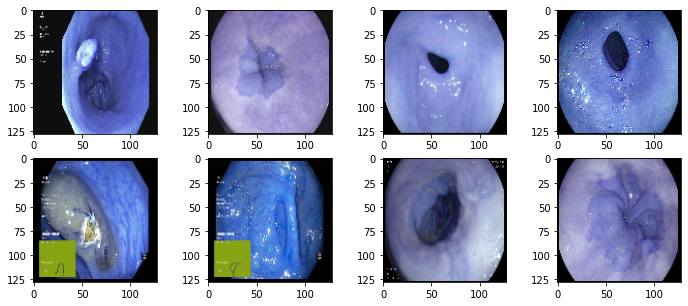

In [ ]:
plt.rcParams['figure.figsize']=(12,5)
plt.subplot(2,4,1)
plt.imshow(Images[0])
plt.subplot(2,4,2)
plt.imshow(Images[1])
plt.subplot(2,4,3)
plt.imshow(Images[2])
plt.subplot(2,4,4)
plt.imshow(Images[3])
plt.subplot(2,4,5)
plt.imshow(Images[4])
plt.subplot(2,4,6)
plt.imshow(Images[5])
plt.subplot(2,4,7)
plt.imshow(Images[6])
plt.subplot(2,4,8)
plt.imshow(Images[7])
plt.show()

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,num_conv_layers=conv_layers,
        num_output_channels=[16, 128, 64, 128],positional_emb=positional_emb,**kwargs,):
      super(CCTTokenizer, self).__init__(**kwargs)
      self.conv_model = keras.Sequential()
      for i in range(num_conv_layers):
          self.conv_model.add(layers.Conv2D(num_output_channels[i],kernel_size,stride,padding="valid",use_bias=False,
                  activation="relu",kernel_initializer="he_normal"))
          self.conv_model.add(layers.ZeroPadding2D(padding))
          self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
      self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,  (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal")],
    name="data_augmentation"
                    )

In [ ]:
def create_cct_model(image_size=image_size,input_shape=input_shape,num_heads=num_heads,projection_dim=projection_dim,
    transformer_units=transformer_units):
    inputs = layers.Input(input_shape)
    augmented = data_augmentation(inputs)
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(attention_weights, representation, transpose_a=True)
    weighted_representation = tf.squeeze(weighted_representation, -2)
    logits = layers.Dense(num_classes,activation='softmax')(weighted_representation)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
     metrics=['accuracy',keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),keras.metrics.Recall()],
                )
    history = model.fit(x_train,y_train,batch_size=16,epochs=100,validation_data=[x_test,y_test])
    model.evaluate(x_test,y_test)
    return history

cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/100
225/225 [==============================] - 10s 31ms/step - loss: 1.5859 - accuracy: 0.3328 - top-5-accuracy: 0.8933 - recall_1: 0.1347 - val_loss: 1.0241 - val_accuracy: 0.5425 - val_top-5-accuracy: 0.9975 - val_recall_1: 0.2775
Epoch 2/100
225/225 [==============================] - 7s 30ms/step - loss: 1.1145 - accuracy: 0.4939 - top-5-accuracy: 0.9942 - recall_1: 0.3197 - val_loss: 0.9298 - val_accuracy: 0.5500 - val_top-5-accuracy: 1.0000 - val_recall_1: 0.3900
Epoch 3/100
225/225 [==============================] - 6s 27ms/step - loss: 0.9536 - accuracy: 0.5522 - top-5-accuracy: 0.9981 - recall_1: 0.4256 - val_loss: 1.0558 - val_accuracy: 0.5450 - val_top-5-accuracy: 0.9925 - val_recall_1: 0.3325
Epoch 4/100
225/225 [==============================] - 7s 29ms/step - loss: 0.9009 - accuracy: 0.5622 - top-5-accuracy: 0.9981 - recall_1: 0.4586 - val_loss: 0.8671 - val_accuracy: 0.6000 - val_top-5-accuracy: 0.9975 - val_recall_1: 0.5250
Epoch 5/100
225/225 [==================

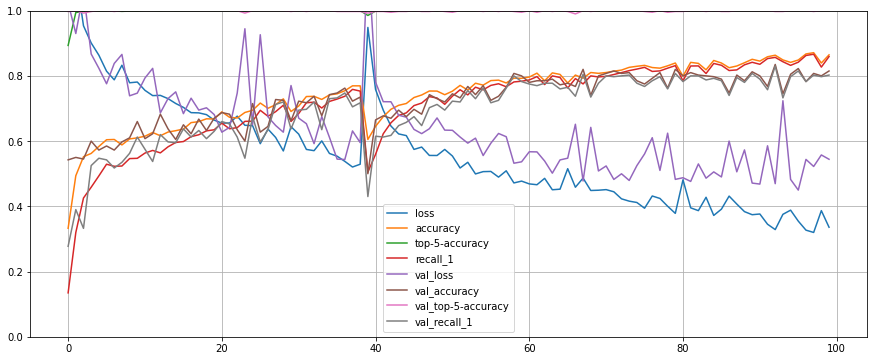

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1))

13/13 [==============================] - 0s 16ms/step


array([[55,  1,  0,  1,  0,  0,  3,  2],
       [20, 21,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  8,  0,  0],
       [ 0,  0,  0, 52,  0,  0,  3,  0],
       [ 0,  0,  1,  0, 59,  0,  1,  1],
       [ 0,  0,  9,  0,  0, 29,  0,  0],
       [ 0,  0,  2,  7,  1,  0, 39,  4],
       [ 0,  0,  0,  2,  2,  0,  6, 40]])

13/13 [==============================] - 0s 17ms/step


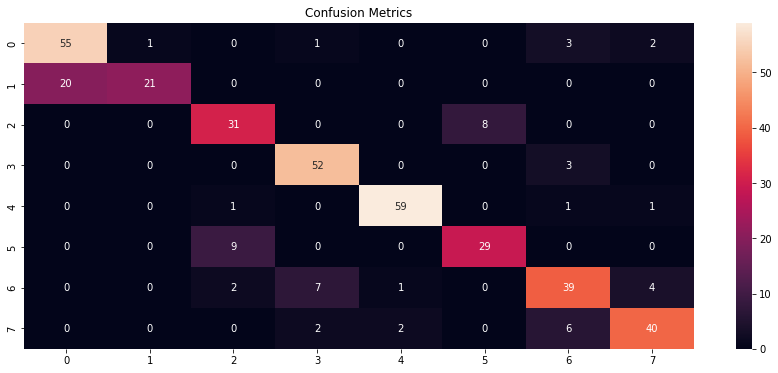

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)),annot=True)
plt.title('Confusion Metrics')
plt.show()